In [1]:
# DO NOT RUN THIS CELL IF YOU ARE EXECUTING THE NOTEBOOK LOCALLY!
# This is purely for setting up the environment on Google Colab

%%capture
!pip install mcramp
!wget https://raw.githubusercontent.com/gcassella/RAMP/5a66408d70622da03ea6062e7d6ad61cc0b14be0/doc/user/powder.json

UsageError: Line magic function `%%capture` not found.


Running simulations
===================

Simulations in RAMP are executed using Python. The architecture of RAMP is contained in the `mcramp` Python package, and is responsible for handling all of the OpenCL operations required to parallelize instrument simulations. 

The basic workflow for RAMP is to write an instrument definition file for your instrument, run the simulation in a Python script, and then analyze the resulting data using standard scientific computing libraries for Python (SciPy, etc.).

The following notebook demonstrates this basic workflow for a simplified powder diffractometer, consisting of a monochromated source, and a sample with a single Bragg peak, described in the instrument definition file `powder.json`.

---------

Initializing an instrument
---------------------------

The snippet below contains a small two line initialization of the OpenCL internals required to identify the device on which the simulations should run. For simulations being run on personal workstations, this will be sufficient and can be safely copied and pasted into any RAMP script.

In [2]:
import mcramp as mcr
import pyopencl as cl
import numpy as np

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

The instrument definition file `powder.json` contains variables `Ei` and `Mono_angle` which we can use to vary the wavelength of incident neutrons. First we shall calculate some values for these variables.

In [3]:
# Physical constants

h=6.62607015e-34
mn=1.674929e-27
meV=1.602176634e-22
overAA = 1e10

Ei = 9.09 # meV - 3AA neutrons
Li = h / np.sqrt(2*mn*Ei*meV) * overAA
Mono_d_spacing = 3.355 # AA
Mono_angle = np.arcsin(Li / (2 * Mono_d_spacing))

The instrument definition file also contains the variable `detector_binning` which we can use to vary the histogram bins in the detector output.

In [4]:
detector_binning = [-40.0, 1.0, 140.0]

Instruments in RAMP are represented by the `Instrument` class, which contains the methods responsible for instantiating, simulating, and obtaining the results of simulations. Instances of the Instrument class are instantiated as follows:

In [5]:
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=Ei, 
    Mono_angle=Mono_angle, 
    detector_binning=detector_binning
)

The constructor for the `Instrument` class takes three arguments by default: the filename of the instrument definition file, the OpenCL context, and the OpenCL queue (the internals we set up earlier). The additional keyword arguments `Ei` and `Mono_angle` correspond to variables in the instrument definition file.

Visualising instruments
-----------------------

The `Instrument` class contains a `visualise()` method which can be used to verify that the instrument geometry specified in a definition file is correct. When rendering visualisations, interactive controls can be used by specifying `controls=True`. However, please note that these controls WILL NOT WORK ON GOOGLE COLAB - but will function on locally executed notebooks using the `%matplotlib widget` magic.

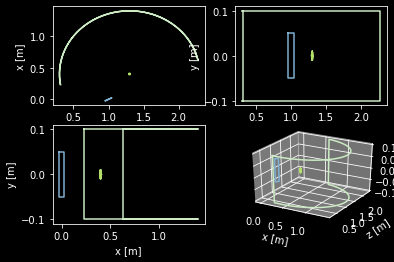

In [6]:
inst.visualise(controls=False)

Even without the interactive controls available, the limits of the instrument visualisation can be manipulated using the `xlim`, `ylim`, `zlim`, and `focus` arguments. Here, `x`, `y`, and `z` refer to the instrument axes - not the axes of any of the plots. That is, `z` is conventionally along the beam direction, and the `xy` plane is perpendicular to this direction with `y` conventionally pointing opposite to the direction of gravity.

The `focus` argument will change the axes such that zero is centered upon the component with the name supplied to `focus`, with the limits a small range around the component.

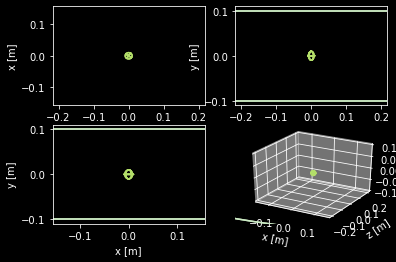

In [7]:
inst.visualise(controls=False, focus='Sample')

Finally, any additional keyword arguments to `visualise()` will be supplied to the `plt.figure()` call used to instantiate the figure. This can be used to, for example, change the size of the figure.

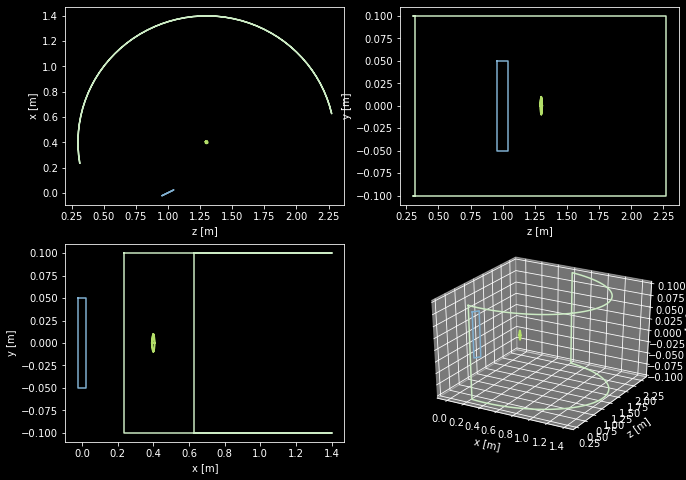

In [8]:
inst.visualise(controls=False, figsize=(11,8))

Executing simulations
---------------------

Simulations are executed by calling the `execute(N)` method of the `Instrument` class, where the argument `N` is the desired number of neutron histories to be simulated.

In [9]:
N = int(1e7)
inst.execute(N)

Plotting simulation results
---------------------------

The easiest way to get a quick visual confirmation that a simulation has returned sensible results is by plotting the output of the instrument monitors using the `plot()` method of the `Instrument` class. This will do some default plotting using `matplotlib` of the histograms of all the detectors in the instrument.

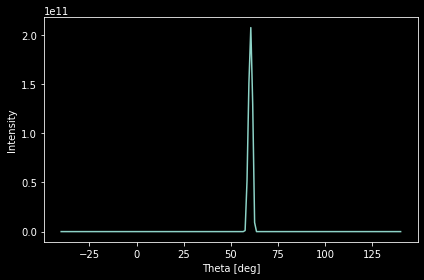

In [10]:
inst.plot()

We can see that there is a peak at approximately 60 degrees. Let's adjust the detector binning and re-run the simulation to obtain a better view of the peak shape.

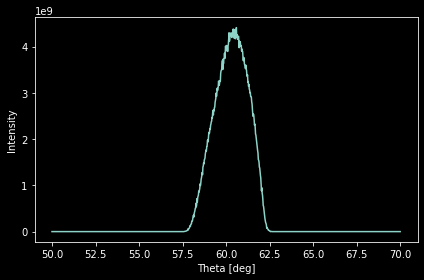

In [11]:
detector_binning = [50.0, 0.02, 70.0]
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=Ei, 
    Mono_angle=Mono_angle, 
    detector_binning=detector_binning
)
N = int(1e7)
inst.execute(N)
inst.plot()

Pretty ugly, but not surprising for such a crude instrument.

Analysing simulation results
----------------------------
To perform a more detailed analysis of the detector output, we can obtain the histogram using the `data()` method of the `Instrument` class. This method returns a dictionary whose keys are the names of components in the instrument definition and whose values are data produced by the corresponding component. Typically this will be non-zero for detectors which provide their axes and histogrammed intensities.

In [12]:
data = inst.data()
print(data)

6.91691692, 66.93693694, 66.95695696, 66.97697698, 66.996997  ,
       67.01701702, 67.03703704, 67.05705706, 67.07707708, 67.0970971 ,
       67.11711712, 67.13713714, 67.15715716, 67.17717718, 67.1971972 ,
       67.21721722, 67.23723724, 67.25725726, 67.27727728, 67.2972973 ,
       67.31731732, 67.33733734, 67.35735736, 67.37737738, 67.3973974 ,
       67.41741742, 67.43743744, 67.45745746, 67.47747748, 67.4974975 ,
       67.51751752, 67.53753754, 67.55755756, 67.57757758, 67.5975976 ,
       67.61761762, 67.63763764, 67.65765766, 67.67767768, 67.6976977 ,
       67.71771772, 67.73773774, 67.75775776, 67.77777778, 67.7977978 ,
       67.81781782, 67.83783784, 67.85785786, 67.87787788, 67.8978979 ,
       67.91791792, 67.93793794, 67.95795796, 67.97797798, 67.997998  ,
       68.01801802, 68.03803804, 68.05805806, 68.07807808, 68.0980981 ,
       68.11811812, 68.13813814, 68.15815816, 68.17817818, 68.1981982 ,
       68.21821822, 68.23823824, 68.25825826, 68.27827828, 68.2982983 ,


In [13]:
detector_output = data['Detector']
theta_axis = detector_output[0]
intensity = detector_output[1]

With this data in hand, we can now perform some analysis. To find the peak centre, let's naievely fit our lineshape to a Gaussian distribution and find the position of the mean.

In [14]:
from scipy.optimize import curve_fit

func = lambda x, c, mu, sigma: c*np.exp(-(x - mu)**2 / (2*sigma**2))
popt, pcov = curve_fit(func, xdata=theta_axis, ydata=intensity, p0=[1e10, 60.0, 2.5])
print(popt)

[4.39694317e+09 6.03611839e+01 1.02592049e+00]


Giving a peak center of 60.4 degrees (as compared to the nominal answer of 60 degrees exactly for our chosen sample and instrument parameters). Plotting the resulting fit yields...

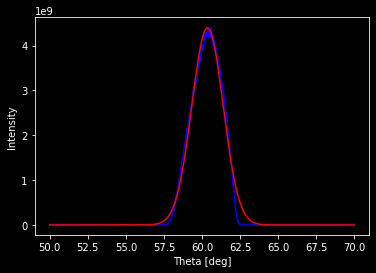

In [15]:
import matplotlib.pyplot as plt

plt.plot(theta_axis, intensity, 'b-')
plt.plot(theta_axis, func(theta_axis, *popt), 'r-')
plt.ylabel("Intensity")
plt.xlabel("Theta [deg]")
plt.show()

Saving simulation results
-------------------------
To save the results of a simulation for analysis at a later date, the `Instrument` class provides the `save()` method. Any component with a `filename` argument in the instrument definition file will save it's `data()` output as a numpy file `filename.npy` when `inst.save()` is  called.

In [16]:
inst.save()